# Angular Distribution of Radiation from a Relativistic Charge
This notebook visualizes the **angular distribution of radiation** emitted by an accelerated charge moving relativistically. We consider a charge with velocity **v** along the z-axis and acceleration **a** in an arbitrary direction.


In [23]:
import sys
import numpy as np

!{sys.executable} -m pip install --quiet matplotlib ipywidgets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import ipywidgets as widgets
from IPython.display import display

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip


# Physics Background

## 1. Key Parameters

We define:
- $\beta = v/c$ (velocity in units of speed of light)
- $\gamma = 1/\sqrt{1-\beta^2}$ (Lorentz factor)
- $\theta$ = polar angle in lab frame (angle from z-axis)
- $\phi$ = azimuthal angle in lab frame
- $\alpha$ = tilt angle of acceleration from z-axis
- $\phi_a$ = azimuthal angle of acceleration direction

## 2. Observed Angular Distribution

The **observed** radiated power per unit solid angle is:

$$\frac{dP_A}{d\Omega} = \frac{q^2 a'^2}{4\pi c^3} \frac{\sin^2\theta'}{\gamma^4 (1-\beta\cos\theta)^4}$$

where $\theta'$ is the angle in the rest frame, related to lab frame angles by:

$$\cos\theta' = \cos\alpha\cos\Theta + \sin\alpha\sin\Theta\cos(\phi - \phi_a)$$

Here $\Theta$ is related to $\theta$ through aberration:
$$\mu = \cos\theta = \frac{\cos\Theta + \beta}{1 + \beta\cos\Theta}$$

For visualization, we use $\Theta \approx \theta$ as the leading approximation.


# Define Functions


In [24]:
def compute_theta_prime(theta, phi, alpha, phi_a):
    cos_theta_prime = np.cos(alpha) * np.cos(theta) + np.sin(alpha) * np.sin(theta) * np.cos(phi - phi_a)
    cos_theta_prime = np.clip(cos_theta_prime, -1.0, 1.0)
    theta_prime = np.arccos(cos_theta_prime)
    return theta_prime


In [25]:
def angular_distribution(theta, phi, beta, alpha, phi_a):
    gamma = 1.0 / np.sqrt(1.0 - beta**2)
    theta_prime = compute_theta_prime(theta, phi, alpha, phi_a)
    
    numerator = np.sin(theta_prime)**2
    denominator = gamma**4 * (1.0 - beta * np.cos(theta))**4
    denominator = np.maximum(denominator, 1e-10)
    
    F = numerator / denominator
    return F


In [26]:
def spherical_to_cartesian(r, theta, phi):
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z


# Example: Parallel Acceleration


First, let's visualize the special case where acceleration is parallel to velocity ($\alpha = 0$). In this case, the radiation is strongly beamed in the forward direction for high $\gamma$.


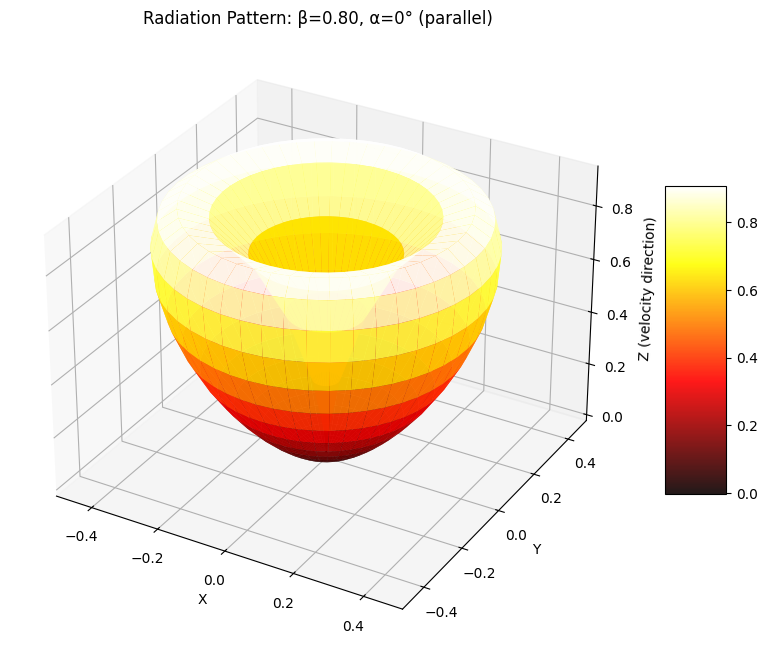

In [27]:
n_theta = 50
n_phi = 50
theta_grid = np.linspace(0, np.pi, n_theta)
phi_grid = np.linspace(0, 2*np.pi, n_phi)
theta_mesh, phi_mesh = np.meshgrid(theta_grid, phi_grid)

beta = 0.8
alpha = 0.0
phi_a = 0.0

F = angular_distribution(theta_mesh, phi_mesh, beta, alpha, phi_a)
F_normalized = F / np.max(F)

x, y, z = spherical_to_cartesian(F_normalized, theta_mesh, phi_mesh)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(x, y, z, cmap='hot', alpha=0.9, edgecolor='none')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z (velocity direction)')
ax.set_title(f'Radiation Pattern: β={beta:.2f}, α=0° (parallel)')

fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)

plt.show()


# 3D Visualization


Now create visualizations exploring how the radiation pattern changes with:
- **γ** (Lorentz factor): Controls the degree of relativistic beaming
- **α** (tilt angle): Angle between acceleration and velocity
- **φ_a** (azimuthal angle): Direction of acceleration in the xy-plane

We'll create a grid of plots showing different parameter combinations.


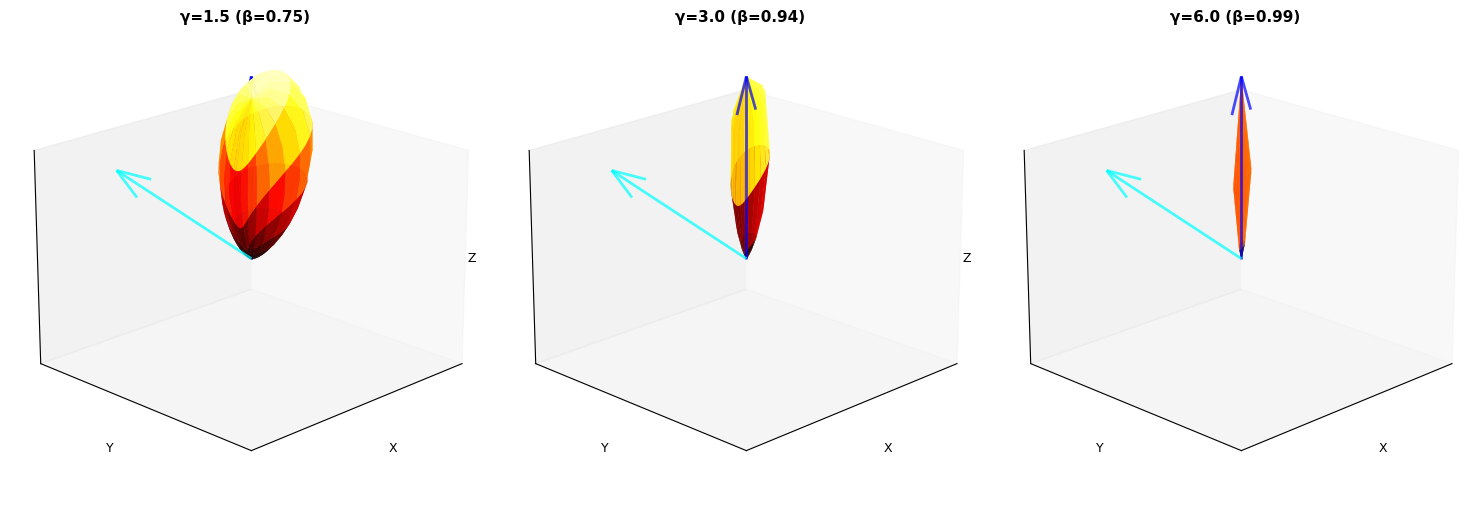

In [28]:
fig = plt.figure(figsize=(15, 5))

gamma_values = [1.5, 3.0, 6.0]
alpha_deg = 45.0
phi_a_deg = 0.0

for i, gamma in enumerate(gamma_values):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    alpha = np.deg2rad(alpha_deg)
    phi_a = np.deg2rad(phi_a_deg)
    beta = np.sqrt(1.0 - 1.0/gamma**2)
    
    n_theta = 40
    n_phi = 40
    theta_grid = np.linspace(0, np.pi, n_theta)
    phi_grid = np.linspace(0, 2*np.pi, n_phi)
    theta_mesh, phi_mesh = np.meshgrid(theta_grid, phi_grid)
    
    F = angular_distribution(theta_mesh, phi_mesh, beta, alpha, phi_a)
    F_normalized = F / np.max(F)
    x, y, z = spherical_to_cartesian(F_normalized, theta_mesh, phi_mesh)
    
    surf = ax.plot_surface(x, y, z, cmap='hot', alpha=0.9, edgecolor='none', 
                           vmin=0, vmax=1, rcount=30, ccount=30)
    
    acc_length = 1.0
    acc_x = acc_length * np.sin(alpha) * np.cos(phi_a)
    acc_y = acc_length * np.sin(alpha) * np.sin(phi_a)
    acc_z = acc_length * np.cos(alpha)
    ax.quiver(0, 0, 0, acc_x, acc_y, acc_z, color='cyan', arrow_length_ratio=0.2, 
              linewidth=2, alpha=0.7)
    ax.quiver(0, 0, 0, 0, 0, acc_length, color='blue', arrow_length_ratio=0.2, 
              linewidth=2, alpha=0.7)
    
    ax.set_xlabel('X', fontsize=9)
    ax.set_ylabel('Y', fontsize=9)
    ax.set_zlabel('Z', fontsize=9)
    
    title = f'γ={gamma:.1f} (β={beta:.2f})'
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    ax.view_init(elev=20, azim=45)
    
    max_range = 0.6
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

#plt.suptitle(f'Relativistic Beaming Effect (α={alpha_deg:.0f}°)', 
#             fontsize=14, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()


# Key Physical Insights

## Relativistic Beaming
As γ increases, the radiation becomes increasingly concentrated in the forward direction (along the velocity). This is the **relativistic beaming** effect.

## Acceleration Direction
- **α = 0°** (parallel): Maximum beaming, symmetric about z-axis
- **α = 90°** (perpendicular): Radiation still beamed forward, but with asymmetric lobes
- **α = 180°** (antiparallel): Similar to parallel case but with different intensity

## The Headlight Effect
For large γ, most radiation is emitted within a cone of half-angle $\sim 1/\gamma$ around the velocity direction, regardless of acceleration direction.



# Effect of Acceleration Direction

Explore how the tilt angle α (angle between acceleration and velocity) affects the radiation pattern.


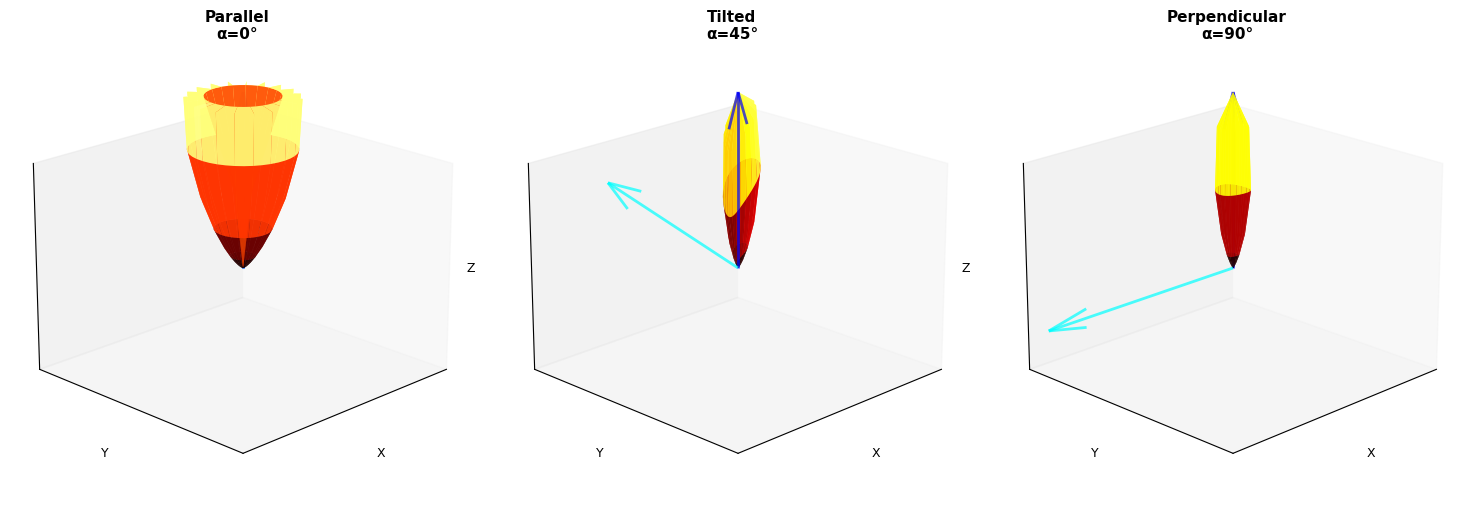

In [29]:
fig = plt.figure(figsize=(15, 5))

gamma = 3.0
alpha_values = [0.0, 45.0, 90.0]
phi_a_deg = 0.0

for i, alpha_deg in enumerate(alpha_values):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    
    alpha = np.deg2rad(alpha_deg)
    phi_a = np.deg2rad(phi_a_deg)
    beta = np.sqrt(1.0 - 1.0/gamma**2)
    
    n_theta = 40
    n_phi = 40
    theta_grid = np.linspace(0, np.pi, n_theta)
    phi_grid = np.linspace(0, 2*np.pi, n_phi)
    theta_mesh, phi_mesh = np.meshgrid(theta_grid, phi_grid)
    
    F = angular_distribution(theta_mesh, phi_mesh, beta, alpha, phi_a)
    F_normalized = F / np.max(F)
    x, y, z = spherical_to_cartesian(F_normalized, theta_mesh, phi_mesh)
    
    surf = ax.plot_surface(x, y, z, cmap='hot', alpha=0.9, edgecolor='none',
                           vmin=0, vmax=1, rcount=30, ccount=30)
    
    acc_length = 1.0
    acc_x = acc_length * np.sin(alpha) * np.cos(phi_a)
    acc_y = acc_length * np.sin(alpha) * np.sin(phi_a)
    acc_z = acc_length * np.cos(alpha)
    ax.quiver(0, 0, 0, acc_x, acc_y, acc_z, color='cyan', arrow_length_ratio=0.2,
              linewidth=2, alpha=0.7)
    ax.quiver(0, 0, 0, 0, 0, acc_length, color='blue', arrow_length_ratio=0.2,
              linewidth=2, alpha=0.7)
    
    ax.set_xlabel('X', fontsize=9)
    ax.set_ylabel('Y', fontsize=9)
    ax.set_zlabel('Z', fontsize=9)
    
    if alpha_deg == 0:
        acc_type = "Parallel"
    elif alpha_deg == 90:
        acc_type = "Perpendicular"
    else:
        acc_type = "Tilted"
    
    title = f'{acc_type}\nα={alpha_deg:.0f}°'
    ax.set_title(title, fontsize=11, fontweight='bold')
    
    ax.view_init(elev=20, azim=45)
    
    max_range = 0.6
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])

#plt.suptitle(f'Effect of Acceleration Direction (γ={gamma:.1f})',
 #            fontsize=14, fontweight='bold', y=0.95)
plt.tight_layout()
plt.show()


# Summary

This notebook demonstrates the angular distribution of radiation from a relativistic accelerated charge. Key features:

1. **Relativistic beaming**: Radiation is concentrated in the forward direction for high γ
2. **Acceleration direction matters**: The tilt angle α and azimuthal angle φₐ affect the pattern shape
3. **Physical origin**: The pattern arises from the Lorentz transformation of dipole radiation from the rest frame
4. **Applications**: Synchrotron radiation, bremsstrahlung, and astrophysical jets

The formula implemented is:

$$\frac{dP_A}{d\Omega} \propto \frac{\sin^2\theta'}{\gamma^4 (1-\beta\cos\theta)^4}$$

where $\theta'$ depends on both the observation direction and the acceleration direction.


## Using the controls

- Drag the sliders to set β, α, and the azimuthal angle φₐ of the acceleration vector.
- Adjust the surface resolution, colormap, and camera angles to highlight specific features.
- Toggle the guideline vectors to focus purely on the radiation surface if desired.


In [ ]:
def render_radiation_pattern(beta, alpha_deg, phi_a_deg, resolution, cmap, elev, azim, show_vectors):
    beta = np.clip(beta, 0.01, 0.999)
    resolution = int(max(20, resolution))
    alpha = np.deg2rad(alpha_deg)
    phi_a = np.deg2rad(phi_a_deg)
    gamma = 1.0 / np.sqrt(1.0 - beta**2)
    
    theta_grid = np.linspace(0.0, np.pi, resolution)
    phi_grid = np.linspace(0.0, 2.0 * np.pi, resolution)
    theta_mesh, phi_mesh = np.meshgrid(theta_grid, phi_grid)
    
    F = angular_distribution(theta_mesh, phi_mesh, beta, alpha, phi_a)
    F_max = np.max(F)
    F_normalized = F / F_max if F_max > 0 else F
    x, y, z = spherical_to_cartesian(F_normalized, theta_mesh, phi_mesh)
    
    fig = plt.figure(figsize=(8.5, 7.0))
    ax = fig.add_subplot(111, projection='3d')
    surface_density = min(80, resolution)
    surf = ax.plot_surface(
        x, y, z,
        cmap=cmap,
        alpha=0.92,
        edgecolor='none',
        rcount=surface_density,
        ccount=surface_density
    )
    
    if show_vectors:
        acc_length = 0.9
        acc_x = acc_length * np.sin(alpha) * np.cos(phi_a)
        acc_y = acc_length * np.sin(alpha) * np.sin(phi_a)
        acc_z = acc_length * np.cos(alpha)
        ax.quiver(0, 0, 0, acc_x, acc_y, acc_z, color='cyan', arrow_length_ratio=0.2,
                  linewidth=2, alpha=0.75)
        ax.quiver(0, 0, 0, 0, 0, acc_length, color='blue', arrow_length_ratio=0.2,
                  linewidth=2, alpha=0.65)
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z (velocity)')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.view_init(elev=elev, azim=azim)
    max_range = 0.65
    ax.set_xlim([-max_range, max_range])
    ax.set_ylim([-max_range, max_range])
    ax.set_zlim([-max_range, max_range])
    ax.set_box_aspect((1, 1, 1))
    title = f'β={beta:.3f} (γ={gamma:.2f}) | α={alpha_deg:.1f}°, φₐ={phi_a_deg:.1f}°'
    ax.set_title(title, fontsize=12, fontweight='bold')
    
    mappable = cm.ScalarMappable(cmap=cmap)
    mappable.set_array(F_normalized)
    colorbar = fig.colorbar(mappable, ax=ax, shrink=0.65, pad=0.12)
    colorbar.set_label('Normalized dP/dΩ')
    plt.show()


beta_slider = widgets.FloatSlider(value=0.8, min=0.05, max=0.999, step=0.01,
                                  description='β', readout_format='.3f')
alpha_slider = widgets.FloatSlider(value=45.0, min=0.0, max=180.0, step=1.0,
                                   description='α (deg)', readout_format='.0f')
phi_slider = widgets.FloatSlider(value=0.0, min=0.0, max=360.0, step=5.0,
                                 description='φₐ (deg)', readout_format='.0f')
resolution_slider = widgets.IntSlider(value=40, min=20, max=80, step=5,
                                      description='Grid N')
cmap_dropdown = widgets.Dropdown(
    options=['plasma', 'magma', 'inferno', 'viridis', 'cividis', 'hot'],
    value='plasma', description='Colormap'
)
elev_slider = widgets.IntSlider(value=20, min=0, max=80, step=5, description='Elev')
azim_slider = widgets.IntSlider(value=45, min=-180, max=180, step=5, description='Azim')
vector_checkbox = widgets.Checkbox(value=True, description='Show vectors')

controls = dict(
    beta=beta_slider,
    alpha_deg=alpha_slider,
    phi_a_deg=phi_slider,
    resolution=resolution_slider,
    cmap=cmap_dropdown,
    elev=elev_slider,
    azim=azim_slider,
    show_vectors=vector_checkbox,
)

interactive_plot = widgets.interactive_output(render_radiation_pattern, controls)
interactive_plot.layout.height = '620px'
interactive_plot.layout.flex = '1 1 0%'

control_column = widgets.VBox([
    widgets.HTML('<b>Radiation parameters</b>'),
    beta_slider,
    alpha_slider,
    phi_slider,
    widgets.HTML('<b>Visualization</b>'),
    resolution_slider,
    cmap_dropdown,
    elev_slider,
    azim_slider,
    vector_checkbox,
], layout=widgets.Layout(width='320px'))

ui = widgets.HBox([control_column, interactive_plot],
                  layout=widgets.Layout(align_items='center', width='100%'))

display(ui)
